In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import njit

g = globals()

In [38]:
def Plot_Opinion_Distribution_2d(data1, data2, data_act):
    op1_list = data1
    op2_list = data2

    fig, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].set_title("Topic 1")
    ax[0].set_xlabel("Opinion")
    ax[0].set_ylabel("# of Opinions on Topic 1")
    ax[0].hist(op1_list, bins=200, density=True)
    ax[1].set_title("Topic 2")
    ax[1].set_xlabel("Opinion")
    ax[1].set_ylabel("# of Opinions on Topic 2")
    ax[1].hist(op2_list, bins=200, density=True)
    ax[2].set_title("Opinion-Space")
    ax[2].set_xlabel("Opinion 1")
    ax[2].set_ylabel("Opinion 2")
    ax[2].scatter(op1_list, op2_list, c=data_act, cmap='cool', marker = '2', alpha=0.25)
    ax[0].set_xlim(-10,10)
    ax[1].set_xlim(-10,10)
    plt.show()

def Agglomerative_Algorithm(data, thresh, runtime, min_nodes):
    # get number of nodes
    N = len(data[0])
    # Declare needed array
    nodes = np.empty((N,3))

    # Fill node array. Last entry is the number of agglom. nodes, first two
    # are the opinion of the node. Last one is its index
    for i in range(N):
        nodes[i][0] = data[len(data)-2][i]
        nodes[i][1] = data[len(data)-1][i]
        nodes[i][2] = 1

    node_count = N

    final_nodes = []

    # Avoid cases where all nodes are cut off, which results in an empty array
    # of final_nodes which results in an error for the classifier
    while len(final_nodes) == 0:

        # Start simulations
        t = 0
        while t < runtime:
            # Create current index array
            inds = np.arange(0, len(nodes), 1, dtype=int)

            # Prepare arrays that save newly created nodes and the ones that were 
            # deleted in the iteration
            nodes_new = []
            deletes = []

            for i in range(len(nodes)):
                # Skip nodes that were merged
                if (i in inds) == True and len(inds)>1:
                    # Make sure that the loop stops if all nodes were merged.
                    # Loop only continues if atleast 2 nodes are left to be merged
                    if node_count > 1:
                        # Pick random entry of nodes
                        rand = i
                        while rand == i or rand == -1:
                            rand = np.random.choice(inds)
                            rand_node = nodes[rand]

                        # Calculate opinion distance
                        op_dist = np.sqrt( (rand_node[0]-nodes[i][0])**2 + (rand_node[1]-nodes[i][1])**2 )
                        # Implement threshold
                        if op_dist < thresh:

                            # Delete used nodes from indice index
                            count = []
                            for j in range (len(inds)):
                                if inds[j] == i or inds[j] == int(rand):
                                    count.append(j)
                            inds = np.delete(inds, count)

                            deletes.append(i)
                            deletes.append(int(rand))
                                    
                            # Extract numbers of nodes
                            n1 = int(nodes[i][2])
                            n2 = int(rand_node[2])
                            # Calculate and append new opinions and number of agglom. nodes
                            avr1 = ( n1*nodes[i][0] + n2*rand_node[0]) / (n1+n2)
                            avr2 = ( n1*nodes[i][1] + n2*rand_node[1]) / (n1+n2)
                            n = n1+n2
                            nodes_new.append( [avr1, avr2, n] )
                            node_count -= 1
                    else:
                        # Stop loop if not enough nodes are left to be merged.
                        break

            # Delete old nodes
            nodes = np.delete( nodes, deletes, axis=0 )

            # Append new nodes to nodes array
            
            if nodes_new != []:
                nodes = np.append(nodes, nodes_new, axis=0)
        
            t += 1

        # Only return nodes with #nodes >= min_nodes
        final_nodes = []
        for i in range (len(nodes)):
            if nodes[i][2] >= min_nodes:
                final_nodes.append( nodes[i] )
        final_nodes = np.array( final_nodes )
    
    # return last list only containing opinion and number of nodes
    return final_nodes


def Agglomerative_Classifier(frac, sims, num_aggs):

    if num_aggs % 2 == 0:
        print("ERROR! Uneven number of agglomerative runs is needed.\n")
        return 0

    alphas = np.arange(0.0, 4.1, 0.1)
    cosds = np.arange(-0.25, 1.05, 0.05)
    beta = 5.0

    saves = np.zeros((len(alphas), len(cosds)))

    for i in range(len(alphas)):
        for j in range(len(cosds)):
            
            # Count wether algorithm says dataset is consensus, polarization or ideology
            # First entry is cons-counter, 2nd polarization and 3rd ideology
            counts = np.zeros(3, dtype=int)
            for k in range(sims):
                
                # Load data
                if k == 0:
                    df = pd.read_csv(f"D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Moderator\\a{alphas[i]:.1f}_b{beta}_cosd{cosds[j]:.2f}_N1000_inf10_minf100.csv", header = None)
                    data = df.to_numpy()
                else:
                    df = pd.read_csv(f'D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Moderator\Gaussian_a{alphas[i]:.1f}_b{beta}_cosd{cosds[j]:.2f}_N1000_inf10_minf100.csv', header = None)
                    data = df.to_numpy()
                # Number of nodes
                N = len(data[0])
                # Neglect nodes that stay around zero.
                sorts = np.argsort( data[0] )
                # Transpose to access nodes
                sorted = data.T[sorts]
                Num = int(N * (1-frac))
                # Transpose back
                data = sorted[:Num].T

                # Create counting array
                for l in range (num_aggs):
                    print(f"i: {i};\tj: {j};\tk: {k}\tl: {l}")
                    # Perform algorithm and classify via angles of nodes
                    last_nodes = Agglomerative_Algorithm(data, 1.0, 150, 100)
                    # Each entry of angle_count represents number of nodes in a quadrant.
                    angle_count = np.zeros(4, dtype = int)
                    # Sort the nodes into nodes that have |op_i|<1 and those that don´t
                    cons_nodes = []
                    pol_nodes = []
                    tol = 30*2*np.pi/360
                    for node in last_nodes:
                        angle = np.arctan2(node[0], node[1])
                        if angle >= np.pi/4 - tol and angle <= np.pi/4 + tol:
                            angle_count[0] += 1
                        if angle >= 3*np.pi/4 - tol and angle <= 3*np.pi/4 + tol:
                            angle_count[1] += 1
                        if angle >= -3*np.pi/4 - tol and angle <= -3*np.pi/4 + tol:
                            angle_count[2] += 1
                        if angle >= -np.pi/4 - tol and angle <= -np.pi/4 + tol:
                            angle_count[3] += 1
                        # Check wether each of the nodes absolute opinions are smaller than one
                        if abs(node[0]) <= 0.5 and abs(node[1]) <= 0.5:
                            cons_nodes.append(node)
                        else:
                            pol_nodes.append(node)

                    # Now classify which of the three states is present
                    # If the nodes in |op1| < 1 and |op2| < 1 have more nodes than the others,
                    # consensus happens
                    if len(cons_nodes) != 0:
                        node_sum1 = 0
                        node_sum2 = 0
                        for node in cons_nodes:
                            node_sum1 += node[2]
                        for node in pol_nodes:
                            node_sum2 += node[2]
                        if node_sum1 >= node_sum2:
                            counts[0] += 1    
                            continue
                    # Check the other cases
                    elif angle_count[0] != 0 and angle_count[2] != 0 and angle_count[1] == 0 and angle_count[3] == 0:
                        counts[2] += 1
                        continue
                    elif angle_count[1] != 0 and angle_count[3] != 0 and angle_count[0] == 0 and angle_count[2] == 0:
                        counts[2] += 1
                        continue
                    elif angle_count[1] != 0 and angle_count[3] != 0 and angle_count[0] != 0 and angle_count[2] != 0:
                        counts[1] += 1 
                        continue

                
            saves[i][j] = np.argmax(counts)

    pd.DataFrame(saves).to_csv(f"D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Moderator\Heatmap_mod.csv", index = False, header = False)
    return saves
                    

            




In [8]:
res = Agglomerative_Classifier(0.0, 1, 5)

i: 0;	j: 0;	k: 0	l: 0
i: 0;	j: 0;	k: 0	l: 1
i: 0;	j: 0;	k: 0	l: 2
i: 0;	j: 0;	k: 0	l: 3
i: 0;	j: 0;	k: 0	l: 4
i: 0;	j: 1;	k: 0	l: 0
i: 0;	j: 1;	k: 0	l: 1
i: 0;	j: 1;	k: 0	l: 2
i: 0;	j: 1;	k: 0	l: 3
i: 0;	j: 1;	k: 0	l: 4
i: 0;	j: 2;	k: 0	l: 0
i: 0;	j: 2;	k: 0	l: 1
i: 0;	j: 2;	k: 0	l: 2
i: 0;	j: 2;	k: 0	l: 3
i: 0;	j: 2;	k: 0	l: 4
i: 0;	j: 3;	k: 0	l: 0
i: 0;	j: 3;	k: 0	l: 1
i: 0;	j: 3;	k: 0	l: 2
i: 0;	j: 3;	k: 0	l: 3
i: 0;	j: 3;	k: 0	l: 4
i: 0;	j: 4;	k: 0	l: 0
i: 0;	j: 4;	k: 0	l: 1
i: 0;	j: 4;	k: 0	l: 2
i: 0;	j: 4;	k: 0	l: 3
i: 0;	j: 4;	k: 0	l: 4
i: 0;	j: 5;	k: 0	l: 0
i: 0;	j: 5;	k: 0	l: 1
i: 0;	j: 5;	k: 0	l: 2
i: 0;	j: 5;	k: 0	l: 3
i: 0;	j: 5;	k: 0	l: 4
i: 0;	j: 6;	k: 0	l: 0
i: 0;	j: 6;	k: 0	l: 1
i: 0;	j: 6;	k: 0	l: 2
i: 0;	j: 6;	k: 0	l: 3
i: 0;	j: 6;	k: 0	l: 4
i: 0;	j: 7;	k: 0	l: 0
i: 0;	j: 7;	k: 0	l: 1
i: 0;	j: 7;	k: 0	l: 2
i: 0;	j: 7;	k: 0	l: 3
i: 0;	j: 7;	k: 0	l: 4
i: 0;	j: 8;	k: 0	l: 0
i: 0;	j: 8;	k: 0	l: 1
i: 0;	j: 8;	k: 0	l: 2
i: 0;	j: 8;	k: 0	l: 3
i: 0;	j: 8;	k: 0	l: 4
i: 0;	j: 9

[[ -0.81450497   0.90439924 354.        ]
 [  1.14754326  -1.1381114  409.        ]
 [  0.90779846   0.75808965 445.        ]
 [ -0.93985425  -0.9457502  356.        ]]
4
[[ -1.01330751  -1.01751404 443.        ]
 [  0.97015907  -0.95742265 385.        ]
 [  1.03875503   1.03639718 452.        ]
 [ -0.86955977   0.87234713 466.        ]]
4
[[  0.93038454  -0.92444056 291.        ]
 [ -1.01971975   1.02185104 483.        ]
 [ -0.89389447  -0.90650432 393.        ]
 [  0.94654909   0.95015728 421.        ]]
4


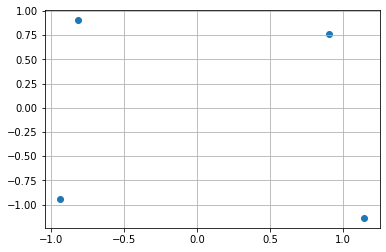

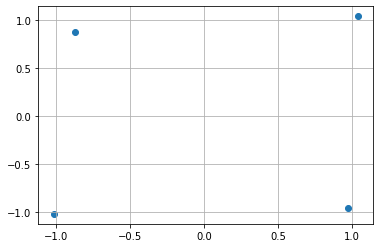

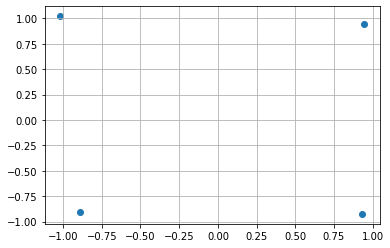

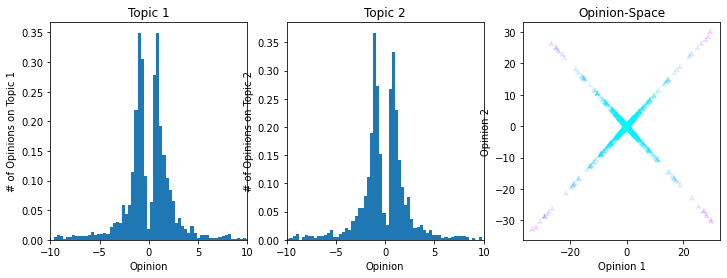

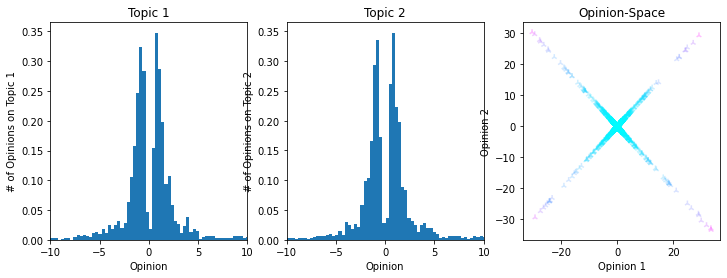

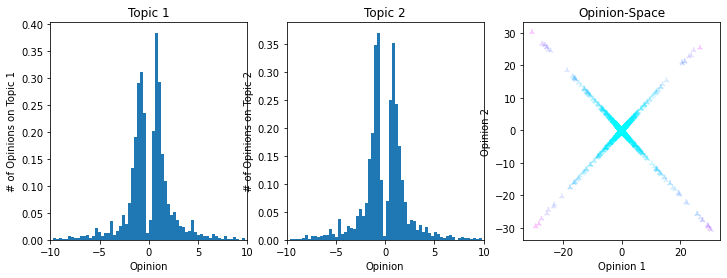

[2.41219417 2.36736437 2.36859374]


In [41]:
# Trying out for single datasets


# Load dataset
#df = pd.read_csv(f'D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Original\\a4.0_b5.0_cosd-0.20.csv', header = None)
df = pd.read_csv(f'D:/Daten mit Änderungen/Physik/Bachelorarbeit/Generated_Data/Original\\a3.0_Polarization_MF_1.csv', header = None)
#df = pd.read_csv(f'D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Distributions\Gaussian_a{3.0:.1f}_b{5.0}_cosd{0.2:.2f}_m{0.5}_std{0.1}_{2}.csv', header = None)
data = df.to_numpy()

df = pd.read_csv(f'D:/Daten mit Änderungen/Physik/Bachelorarbeit/Generated_Data/Original\\a3.0_Polarization_MF_2.csv', header = None)
data1 = df.to_numpy()

df = pd.read_csv(f'D:/Daten mit Änderungen/Physik/Bachelorarbeit/Generated_Data/Original\\a3.0_Polarization_MF_3.csv', header = None)
data2 = df.to_numpy()

N = len(data[0])

# Exclude bounded nodes
frac = 0.0
# Neglect nodes that stay around zero.
sorts = np.argsort( data[0] )
#print(sorts)
# Transpose to access nodes
sorted = data.T[sorts]
Num = int(N * (1-frac))
# Transpose back
data = sorted[:Num].T

results = Agglomerative_Algorithm(data, 1.0, 200, 200)

print(results)
print(len(results))

plt.figure()
plt.scatter( results[:,0], results[:,1] )
plt.grid()

results1 = Agglomerative_Algorithm(data1, 1.0, 200, 200)

print(results1)
print(len(results1))

plt.figure()
plt.scatter( results1[:,0], results1[:,1] )
plt.grid()

results2 = Agglomerative_Algorithm(data2, 1.0, 200, 200)

print(results2)
print(len(results2))

plt.figure()
plt.scatter( results2[:,0], results2[:,1] )
plt.grid()

Plot_Opinion_Distribution_2d(data[len(data)-2], data[len(data)-1], data[0])
Plot_Opinion_Distribution_2d(data1[len(data1)-2], data1[len(data1)-1], data1[0])
Plot_Opinion_Distribution_2d(data2[len(data2)-2], data2[len(data2)-1], data2[0])

# Problems with classifying transmission from consens to ideology:
# Often one or two more nodes beside the big one in the middle emerge.
# Some cases can still be correctly classified when comparing the size and
# using for example a size-difference of 500 to the node in the middle to
# still classify the whole thing as consensus. Still, one or two paramter-
# pairs will be missclassified.
means = np.zeros(3)
for i in range(len(data[3])):
    means[0] += np.abs(data[3][i])
    means[1] += np.abs(data1[3][i])
    means[2] += np.abs(data2[3][i])
print(means/len(data[3]))

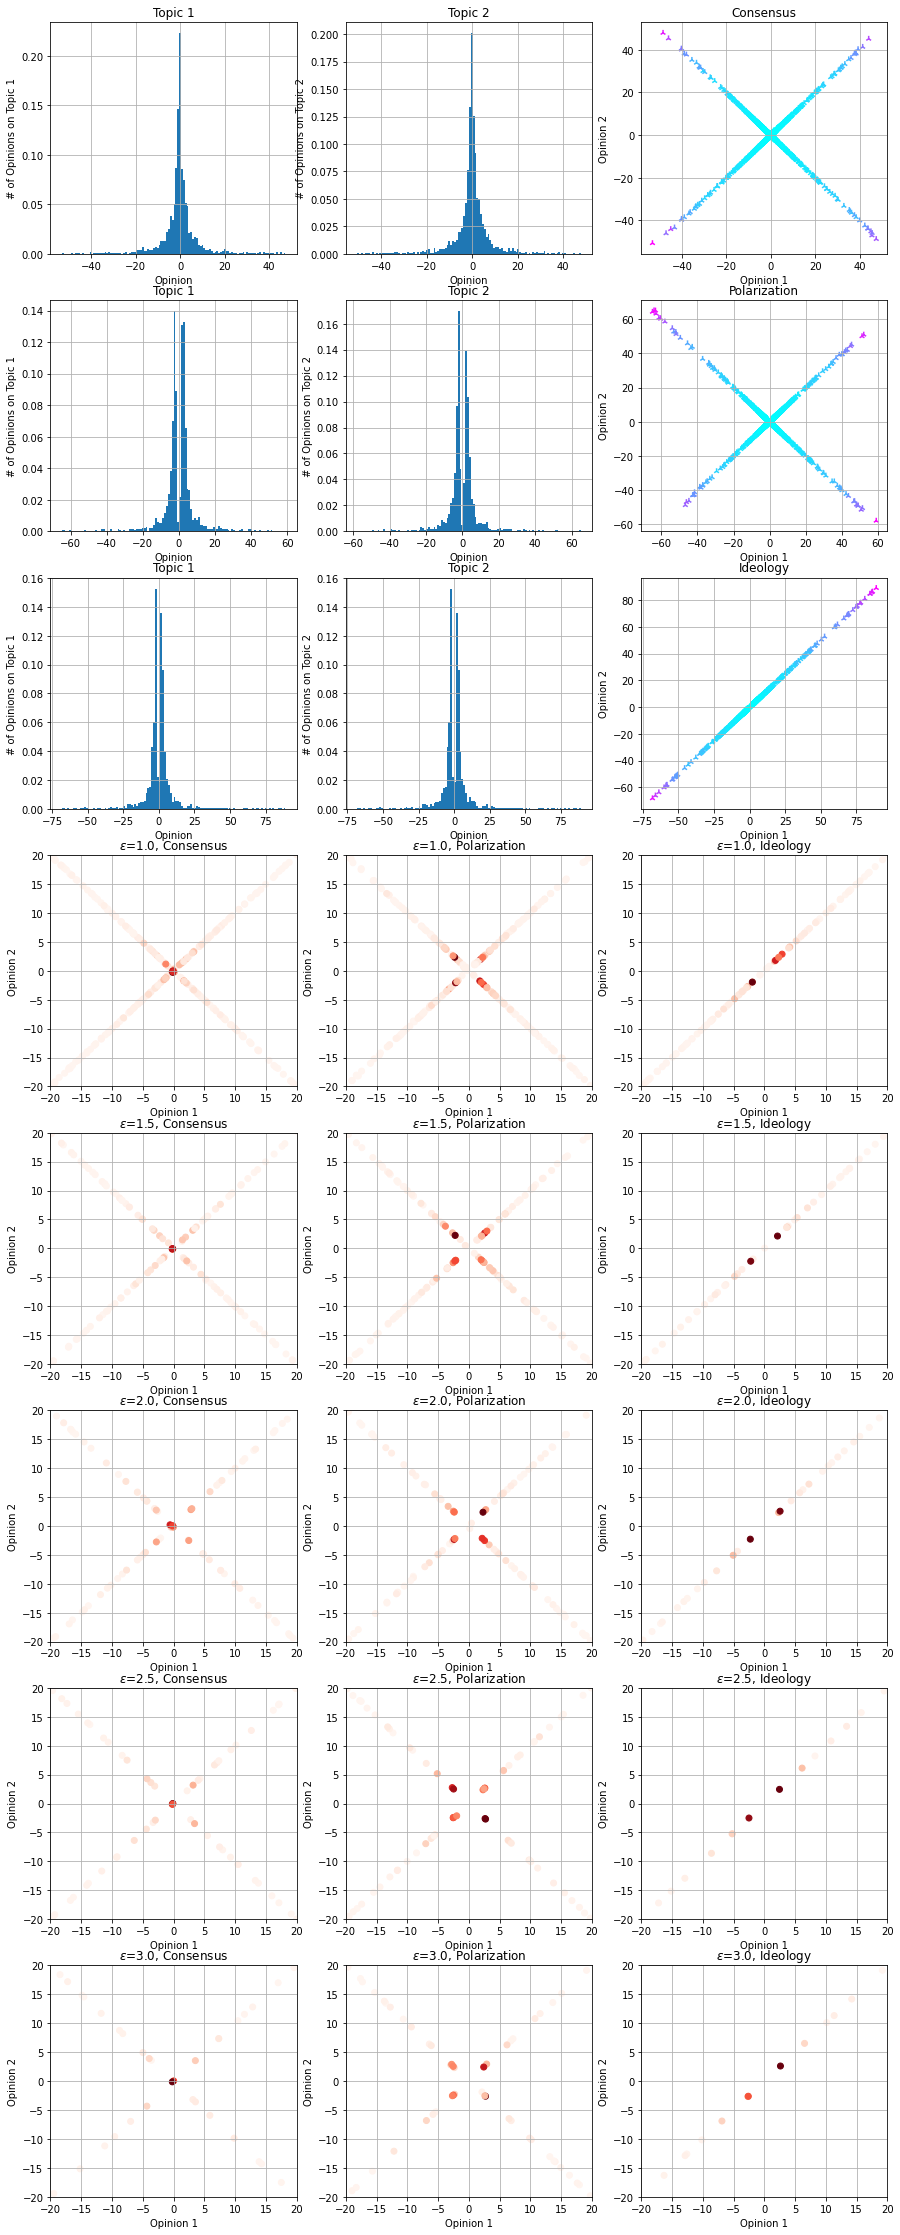

In [37]:
# Comparing different epsilons for diifferent distributions
# Polarization
df = pd.read_csv(f'D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Bound\Phase\\a0.5_b5.0_cosd0.0_frac_0.0_1.csv', header = None)
data1 = df.to_numpy()
# Consensus
df = pd.read_csv(f'D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Bound\Phase\\a3.0_b5.0_cosd0.0_frac_0.0_1.csv', header = None)
data2 = df.to_numpy()
# Ideology
df = pd.read_csv(f'D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Bound\Phase\\a3.0_b5.0_cosd0.8_frac_0.0_1.csv', header = None)
data3 = df.to_numpy()
# No sorting is neccesarry here because no nodes are controlled in these datasets (frac = 0.0)

# Length of datasets
length = len(data1)

eps = [1.0, 1.5, 2.0, 2.5, 3.0]
Titles = ["Consensus", "Polarization", "Ideology"]

fig, ax = plt.subplots(len(eps)+3, 3, figsize=(3 * 5, (len(eps)+3) * 5))
# Plot datasets
for i in range (3):
    ax[i][0].set_title("Topic 1")
    ax[i][0].set_xlabel("Opinion")
    ax[i][0].set_ylabel("# of Opinions on Topic 1")
    ax[i][0].hist(g[f"data{i+1}"][length-2], bins=120, density=True)
    ax[i][1].set_title("Topic 2")
    ax[i][1].set_xlabel("Opinion")
    ax[i][1].set_ylabel("# of Opinions on Topic 2")
    ax[i][1].hist(g[f"data{i+1}"][length-1], bins=120, density=True)
    ax[i][2].set_title(f"{Titles[i]}")
    ax[i][2].set_xlabel("Opinion 1")
    ax[i][2].set_ylabel("Opinion 2")
    ax[i][2].scatter(g[f"data{i+1}"][length-2], g[f"data{i+1}"][length-1], c=g[f"data{i+1}"][0], cmap='cool', marker = '2')
    ax[i][0].grid()
    ax[i][1].grid()
    ax[i][2].grid()
# Plot the classifiers final nodes. Nodes are colored according to the number of nodes they´ve eaten.
for i in range(len(eps)):
    for j in range (3):
        results = Agglomerative_Algorithm(g[f"data{j+1}"], eps[i], 100, 0)
        ax[i+3][j].set_xlabel("Opinion 1")
        ax[i+3][j].set_ylabel("Opinion 2")
        ax[i+3][j].scatter(results[:,0], results[:,1], c=results[:,2], cmap='Reds')
        ax[i+3][j].set_xlim(-20,20)
        ax[i+3][j].set_ylim(-20,20)
        ax[i+3][j].set_title(f"$\epsilon$={eps[i]}, {Titles[j]}")
        ax[i+3][j].grid()

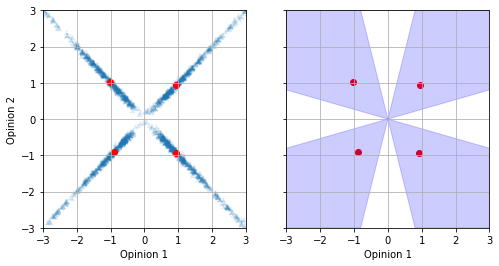

In [65]:
# Creating Plots showing the important zones of the classifier

fig, ax = plt.subplots( 1, 2, figsize=(8,4), sharey=True )
ax[0].scatter(data2[3], data2[4], alpha = 0.15, marker = '2')
ax[0].set_xlim(-3,3)
ax[0].set_ylim(-3,3)
ax[0].scatter(results2[:,0], results2[:,1], color='red')
ax[1].scatter(results2[:,0], results2[:,1], color='red')
ax[1].set_xlim(-3,3)
ax[1].set_ylim(-3,3)
ax[1].grid()
ax[0].grid()
ax[1].add_patch(plt.Polygon([[0,0],[-3,0.80384],[-3,3],[-0.80384,3]], color='blue', alpha=0.2))
ax[1].add_patch(plt.Polygon([[0,0],[-3,-0.80384],[-3,-3],[-0.80384,-3]], color='blue', alpha=0.2))
ax[1].add_patch(plt.Polygon([[0,0],[3,0.80384],[3,3],[0.80384,3]], color='blue', alpha=0.2))
ax[1].add_patch(plt.Polygon([[0,0],[3,-0.80384],[3,-3],[0.80384,-3]], color='blue', alpha=0.2))
ax[1].set_xlabel("Opinion 1")
ax[0].set_xlabel("Opinion 1")
ax[0].set_ylabel("Opinion 2")
plt.savefig("D:\Daten mit Änderungen\Physik\Bachelorarbeit\Figures\Agglom_Radial_Zones", dpi=300)

[[-1.21853963e+00 -1.20186199e+00  3.03000000e+02]
 [ 1.13960863e+00  1.17600741e+00  2.77000000e+02]
 [-5.55544324e-02  4.44292752e-02  7.47000000e+02]
 [-1.18521722e+00  1.16229338e+00  2.75000000e+02]
 [ 1.26507922e+00 -1.29440394e+00  3.04000000e+02]]


(-10.0, 10.0)

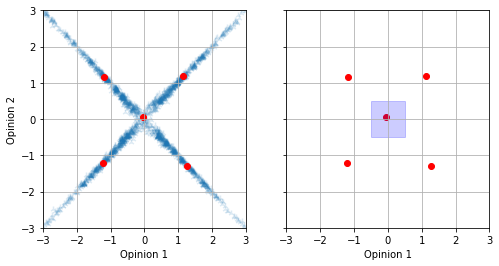

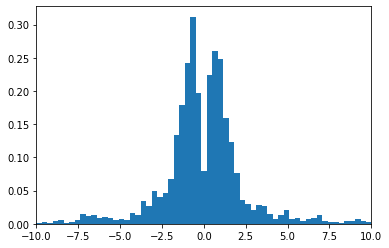

In [66]:
np.random.seed(42)
df = pd.read_csv(f'D:/Daten mit Änderungen/Physik/Bachelorarbeit/Generated_Data/Original\\a1.8_Polarization_MF_2.csv', header = None)
data = df.to_numpy()

results = Agglomerative_Algorithm(data, 1.0, 200, 200)

print(results)

fig, ax = plt.subplots( 1, 2, figsize=(8,4), sharey=True )
ax[0].scatter(data[3], data[4], alpha = 0.15, marker = '2')
ax[0].set_xlim(-3,3)
ax[0].set_ylim(-3,3)
ax[0].scatter(results[:,0], results[:,1], color='red')
ax[1].scatter(results[:,0], results[:,1], color='red')
ax[1].set_xlim(-3,3)
ax[1].set_ylim(-3,3)
ax[1].grid()
ax[0].grid()
ax[1].add_patch(plt.Polygon([[-0.5,0.5],[0.5,0.5],[0.5,-0.5],[-0.5,-0.5]], color='blue', alpha=0.2))

ax[1].set_xlabel("Opinion 1")
ax[0].set_xlabel("Opinion 1")
ax[0].set_ylabel("Opinion 2")
plt.savefig("D:\Daten mit Änderungen\Physik\Bachelorarbeit\Figures\Agglom_Cons_Zone", dpi=300)

plt.figure()
plt.hist(data[3], bins = 200, density=True)
plt.xlim(-10,10)

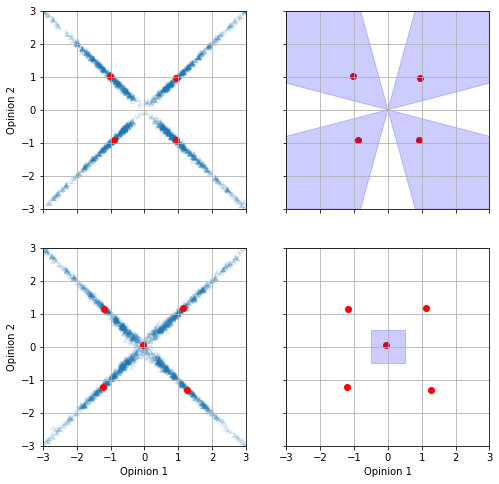

In [69]:
fig, ax = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey=True)
ax[0][0].scatter(data2[3], data2[4], alpha = 0.15, marker = '2')
ax[0][0].set_xlim(-3,3)
ax[0][0].set_ylim(-3,3)
ax[0][0].scatter(results2[:,0], results2[:,1], color='red')
ax[0][1].scatter(results2[:,0], results2[:,1], color='red')
ax[0][1].set_xlim(-3,3)
ax[0][1].set_ylim(-3,3)
ax[0][1].grid()
ax[0][0].grid()
ax[0][1].add_patch(plt.Polygon([[0,0],[-3,0.80384],[-3,3],[-0.80384,3]], color='blue', alpha=0.2))
ax[0][1].add_patch(plt.Polygon([[0,0],[-3,-0.80384],[-3,-3],[-0.80384,-3]], color='blue', alpha=0.2))
ax[0][1].add_patch(plt.Polygon([[0,0],[3,0.80384],[3,3],[0.80384,3]], color='blue', alpha=0.2))
ax[0][1].add_patch(plt.Polygon([[0,0],[3,-0.80384],[3,-3],[0.80384,-3]], color='blue', alpha=0.2))
ax[0][0].set_ylabel("Opinion 2")
ax[1][0].scatter(data[3], data[4], alpha = 0.15, marker = '2')
ax[1][0].set_xlim(-3,3)
ax[1][0].set_ylim(-3,3)
ax[1][0].scatter(results[:,0], results[:,1], color='red')
ax[1][1].scatter(results[:,0], results[:,1], color='red')
ax[1][1].set_xlim(-3,3)
ax[1][1].set_ylim(-3,3)
ax[1][1].grid()
ax[1][0].grid()
ax[1][1].add_patch(plt.Polygon([[-0.5,0.5],[0.5,0.5],[0.5,-0.5],[-0.5,-0.5]], color='blue', alpha=0.2))
ax[1][1].set_xlabel("Opinion 1")
ax[1][0].set_xlabel("Opinion 1")
ax[1][0].set_ylabel("Opinion 2")
plt.savefig("D:\Daten mit Änderungen\Physik\Bachelorarbeit\Figures\Agglom_Zones", dpi=300)